## Google Dreams!
Let's use a Google CNN to hallucinate! When creating dream images we adjust the image to maximize the activation of a certain feature in the CNN (layer, channel combination) this mutates the image into what the feature is looking for. A view into the subconcious of the CNN!

In [1]:
from __future__ import print_function

from io import BytesIO
from functools import partial
from IPython.display import clear_output, Image, display, HTML

import os
import PIL.Image
import numpy as np
import tensorflow as tf

model_fn = 'datasets/dream/tensorflow_inception_graph.pb'

In [2]:
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)

In [3]:
# Read Graph

with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

In [4]:
# Definte the graph using the pd file
# Add an input tensor to feed into the graph

t_input = tf.placeholder(np.float32, name='input') 
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

In [5]:
# Get layer and channel specs -- needed for making a dream

layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

Number of layers 59
Total number of feature channels: 7548


In [6]:
# Helper functions for graph visualization

# Clean graph names
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def

# Reduce memory footprint of graph
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def

# Display graph using TF's framework
def show_graph(graph_def, max_const_size=32):
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(graph_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [7]:
# Display graph structure
renamed_graph_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
cleaned_graph_def = strip_consts(renamed_graph_def)
show_graph(cleaned_graph_def)

In [8]:
# Image helper functions

# Standardize distribution
def clean_img(arr, s=0.1):
    return (arr-arr.mean())/max(arr.std(), 1e-4)*s + 0.5

# Visualize image
def show_img(img, fmt='jpeg'):
    img = np.uint8(np.clip(img, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(img).save(f, fmt)
    display(Image(data=f.getvalue()))

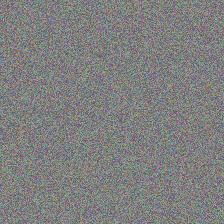

In [9]:
# Noisy image -- where we start our first dream
show_img(clean_img(np.random.uniform(size=(224,224,3)) + 100.0))

In [10]:
# Get channel from graph to morph an image
layer = 'mixed4d_3x3_bottleneck_pre_relu'
channel = 139
feature = graph.get_tensor_by_name("import/%s:0"%layer)[:,:,:,channel]
noise = np.random.uniform(size=(224,224,3)) + 100.0

### Basic Dreaming Algorithn

-19.438198 -32.224483 19.49819 86.24652 161.90993 221.57466 273.641 329.99146 370.28726 411.78348 473.1023 508.37488 547.06537 590.9511 612.9543 650.44226 681.1765 703.53076 727.3959 746.75446 

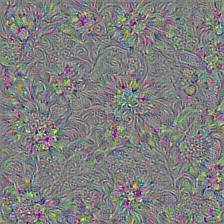

In [11]:
# Gradients to increase activation of the feature we chose
t_score = tf.reduce_mean(feature) 
t_grad = tf.gradients(t_score, t_input)[0]

#Iteratively update the image to maximize the feature response
img = noise.copy()
for i in range(20):
    g, score = sess.run([t_grad, t_score], {t_input:img})
    g /= g.std()+1e-8
    img += g*1.0
    print(score, end = ' ')

show_img(clean_img(img))

In [74]:
def dream(t_obj, img0, iter_n=100, step=1.0):
    t_score = tf.reduce_mean(t_obj)
    t_grad = tf.gradients(t_score, t_input)[0]
    
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {t_input:img})
        g /= g.std()+1e-8
        img += g*step
        print(score, end = ' ')
    clear_output()
    show_img(clean_img(img))

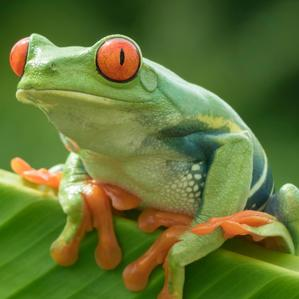

In [82]:
img0 = PIL.Image.open("./images/frog.png")
img0 = np.float32(img0)
show_img(img0/255.0)

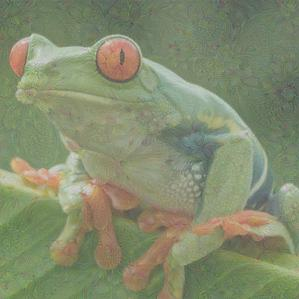

In [76]:
dream(feature,img0)

Meh didnt work that well...